In [3]:
import itertools

# Find maximum overlap bewteen adjacent reads
def max_overlap(a, b, min_length=3):
    start = 0
    while True:
        start = a.find(b[:min_length], start)
        if start == -1:
            return 0
        if b.startswith(a[start:]):
            return len(a) - start
        start += 1

# Find the shortest common superstring on all sorted permutations        
def scs(ss):
    shortest_sup = None
    for ssperm in itertools.permutations(ss):
        sup = ssperm[0]
        for i in range(len(ss) - 1):
            overlap_len = max_overlap(ssperm[i], ssperm[i+1], min_length=1)
            sup += ssperm[i+1][overlap_len:]
        if not shortest_sup or len(sup) < len(shortest_sup):
            shortest_sup = sup
    return shortest_sup

# Run scs
input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
output_string = scs(input_strings)
print(f'Shortest Common Superstring is {output_string} of length {len(output_string)}') 

Shortest Common Superstring is GTACGTACGAT of length 11


In [4]:
# Run greedy scs

# First one is picked when ties.
def pick_maximal_overlap(reads, k): 
    read_a, read_b = None, None
    best_overlap_len = 0
    for a, b in itertools.permutations(reads, 2):
        overlap_len = max_overlap(a, b, min_length=k)
        if overlap_len > best_overlap_len:
            read_a, read_b = a, b
            best_overlap_len = overlap_len
    return read_a, read_b, best_overlap_len

def greedy_scs(reads, k, join=True):
    read_a, read_b, overlap_len = pick_maximal_overlap(reads, k)
    while overlap_len > 0:
        reads.remove(read_a)
        reads.remove(read_b)
        reads.append(read_a + read_b[overlap_len:])
        read_a, read_b, overlap_len = pick_maximal_overlap(reads, k)
    return ''.join(reads) if join else reads

input_strings = [
    'GTACGT',
    'TACGTA',
    'ACGTAC',
    'CGTACG',
    'GTACGA',
    'TACGAT',
]
output_string = greedy_scs(input_strings, 3)
print(f'Shortest Common Superstring is {output_string} of lenght {len(output_string)}')

Shortest Common Superstring is GTACGTACGAT of lenght 11


In [5]:
input_strings = [
    'GTACGT',
    'TACGTA',
]
len(list(itertools.permutations(input_strings, 2)))

2

Iteration 100000
Iteration 200000
Iteration 300000
Best Result GGTACGTAGACATC on 100.0% of the cases


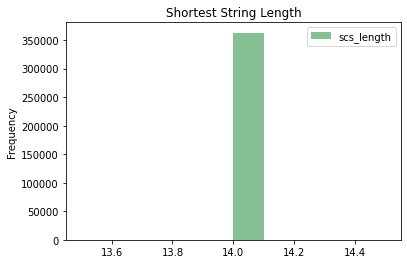

In [45]:
# Run greedy scs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# input_strings = [
#     'GTACGT',
#     'TACGTA',
#     'ACGTAC',
#     'CGTACG',
#     'GTACGA',
#     'TACGAT',
# ]


def create_kmers(input_string, k):
    kmers = []
    for i in range(len(input_string) - k):
        kmers.append(input_string[i:(i + k)])
    kmers.append(input_string[-k:])
    return kmers    

input = 'GGTACGTAGACATC'
input_strings = create_kmers(input, 6)
results = []
k = 0
for ssperm in itertools.permutations(input_strings):
    k += 1
    if k % 100000 == 0:
        print(f'Iteration {k}')
    output_string = greedy_scs(list(ssperm), 2)
    results.append({
        'input': ssperm,
        'output': output_string,
        'scs_length': len(output_string)
    })

df = pd.DataFrame(results)
min_scs = min(df['scs_length'])
max_scs = max(df['scs_length'])
accuracy = len(df[df['scs_length'] == min_scs])/ len(df)

ax = df.plot(
    kind="hist", 
    title='Shortest String Length',
    color='#86bf91',
)

# _ = ax.set_xticks(np.arange(min_scs, max_scs + 1))
# _ = ax.set_xlim([min_scs, max_scs])
print(f'Best Result {input} on {round(accuracy * 100, 2)}% of the cases')


In [35]:
# input_strings = create_kmers('CGTACGTACGATCG', 13)
# # len(list(itertools.permutations(input_strings)))
# input_strings
# # len(input)
results

['CGTACGTACGATC', 'GTACGTACGATCG']

In [12]:
def create_kmers(input_string, k):
    kmers = []
    for i in range(len(input_string) - k):
        kmers.append(input_string[i:(i + k)])
    kmers.append(input_string[-k:])
    return kmers    

input_strings = create_kmers('ATTCGTGCGTCGATT', 6)
len(list(itertools.permutations(input_strings)))

3628800

In [36]:
results[0]

{'input': ('CGTACG',
  'GTACGT',
  'TACGTA',
  'ACGTAC',
  'CGTACG',
  'GTACGA',
  'TACGAT',
  'ACGATC',
  'CGATCG'),
 'output': 'GTACGTACGATCG',
 'scs_length': 13}

In [21]:
set([k['scs_length'] for k in results])

{14}

In [90]:
# Read E. Coli fastq

def process(lines=None):
    ks = ['name', 'sequence', 'optional', 'quality']
    return {k: v for k, v in zip(ks, lines)}

ecoli_fastq = "../datasets/dat_single_end.fq"
reads = []
with open(ecoli_fastq, 'r') as f:
    lines = []
    for line in f:
        lines.append(line.rstrip())
        if len(lines) == 4:
            record = process(lines)
            reads.append(record['sequence'])
            lines = []

In [94]:
%%time

# Run greedy scs on all E. Coli reads
tests = []
for read in reads:    
    results = []
    kmers = create_kmers(read, 6)
    output_string = greedy_scs(kmers, 2)
    tests.append({
        'input': read,
        'solution': output_string,
        'best solution': 1 if read == output_string else 0,
    })

# Check if any test yield the wrong solution
assert any([r['best solution'] for r in tests])

CPU times: user 45.4 s, sys: 253 ms, total: 45.7 s
Wall time: 46.2 s


In [98]:
# Plot
assert any([r['best solution'] for r in tests])
df = pd.DataFrame(tests)

ax = df.plot(
    kind="pie",
    y="best solution",
    title='% Accuracy on finding the best solution',
)

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
%%time

# Read E. Coli fastq

def process(lines=None):
    ks = ['name', 'sequence', 'optional', 'quality']
    return {k: v for k, v in zip(ks, lines)}

ecoli_fastq = "../datasets/dat_single_end.fq"
reads = []
with open(ecoli_fastq, 'r') as f:
    lines = []
    for line in f:
        lines.append(line.rstrip())
        if len(lines) == 4:
            record = process(lines)
            reads.append(record['sequence'])
            lines = []

# Run greedy scs on all E. Coli reads
kmers = []
for read in reads:    
    results = []
    kmers += create_kmers(read, 6)

output_string = greedy_scs(kmers, 2)

In [84]:
# import collections
len('GGGTAGCTGGGATTACAGGCACCTGCCCCGACGCCCAGCTAATTTTTTGT')

# Taking first 10 bp of each E. Coli read
inputs = [r[:10] for r in reads]

False

In [ ]:
%time
tests = []
for i in reads[:]:    
    ssperm = create_kmers(i, 6)
    results = []
    k = 0
    k += 1
    if k % 100000 == 0:
        print(f'Iteration {k}')
    output_string = greedy_scs(list(ssperm), 2)
    results.append({
        'input': ssperm,
        'output': output_string,
        'scs_length': len(output_string)
    })

    df = pd.DataFrame(results)
    min_scs = min(df['scs_length'])
    max_scs = max(df['scs_length'])
    accuracy = len(df[df['scs_length'] == min_scs])/ len(df)
    tests.append({
        'input': i,
        'accuracy': accuracy,
    })